In [1]:
# import packages

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

import networkx as nx
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle




/n/home07/lfesser/.conda/envs/borf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Spectral Gaps

In [99]:
from preprocessing import rewiring, fosr

dataset = list(TUDataset(root="data", name="PROTEINS"))

In [100]:
spectral_gaps = []
for graph in tqdm(dataset):
    G = to_networkx(graph, to_undirected=True)
    # spectral_gap = rewiring.spectral_gap(G)
    spectral_gap = nx.algebraic_connectivity(G)
    spectral_gaps.append(spectral_gap)

100%|██████████| 1113/1113 [00:06<00:00, 177.68it/s]


In [101]:
for i in tqdm(range(len(dataset))):
    edge_index, edge_type, _ = fosr.edge_rewire(dataset[i].edge_index.numpy(), num_iterations=30)
    dataset[i].edge_index = torch.tensor(edge_index)
    dataset[i].edge_type = torch.tensor(edge_type)

100%|██████████| 1113/1113 [00:00<00:00, 2731.09it/s]


In [102]:
fosr_spectral_gaps = []
for graph in tqdm(dataset):
    G = to_networkx(graph, to_undirected=True)
    # spectral_gap = rewiring.spectral_gap(G)
    spectral_gap = nx.algebraic_connectivity(G)
    fosr_spectral_gaps.append(spectral_gap)

100%|██████████| 1113/1113 [00:20<00:00, 53.81it/s]


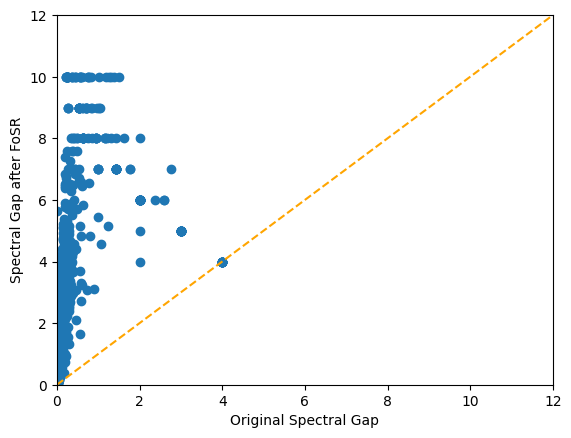

In [47]:
lim = 12

plt.scatter(spectral_gaps, fosr_spectral_gaps)
plt.plot([0, lim], [0, lim], color='orange', linestyle='--')
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Original Spectral Gap")
plt.ylabel("Spectral Gap after FoSR")
# plt.title("Scatter Plot Example")

# Display the plot
plt.show()

In [103]:
class SelectiveRewiring:
    """
    An abstract class that contains static methods for selective rewiring.
    """
    @staticmethod
    def select_borf(graph, dataset_properties):
        """
        Select the rewiring method for the graph.
        """
        average_degree = SelectiveRewiring.get_average_degree(graph)
        edge_density = SelectiveRewiring.get_edge_density(graph)

        if edge_density < dataset_properties['edge_density'][0] and average_degree < dataset_properties['average_degree'][0]:
            return None
        else:
            return 'borf'
        
    @staticmethod
    def select_fosr(graph, dataset_properties):
        """
        Select the rewiring method for the graph.
        """
        average_degree = SelectiveRewiring.get_average_degree(graph)
        edge_density = SelectiveRewiring.get_edge_density(graph)
        algebraic_connectivity = SelectiveRewiring.get_algebraic_connectivity(graph)        

        if algebraic_connectivity < dataset_properties['algebraic_connectivity'][0]:
            return 'fosr'
        else:
            return None
        """
        if edge_density < dataset_properties['edge_density'][0] or average_degree < dataset_properties['average_degree'][0] - dataset_properties['average_degree'][1]:
            if algebraic_connectivity > dataset_properties['algebraic_connectivity'][0]:
                return 'fosr'
            else:
                return None
        else:
            return 'fosr'
        """

    @staticmethod
    def select_rewiring(graph, dataset_properties):
        """
        Select the rewiring method for the graph.
        """
        average_degree = SelectiveRewiring.get_average_degree(graph)
        edge_density = SelectiveRewiring.get_edge_density(graph)
        algebraic_connectivity = SelectiveRewiring.get_algebraic_connectivity(graph)

        if edge_density < dataset_properties['edge_density'][0] and average_degree < dataset_properties['average_degree'][0]:
            return None
        # elif algebraic_connectivity > dataset_properties['algebraic_connectivity'][0]:
            # return 'fosr'
        else:
            return 'borf'

    @staticmethod
    def compute_attributes(dataset):
        """
        Compute the attributes of the dataset.
        """
        dataset_properties = {'average_degree' : [], 'edge_density' : [], 'algebraic_connectivity' : []}

        average_degrees = [SelectiveRewiring.get_average_degree(graph) for graph in dataset]
        edge_densities = [SelectiveRewiring.get_edge_density(graph) for graph in dataset]
        algebraic_connectivities = [SelectiveRewiring.get_algebraic_connectivity(graph) for graph in dataset]

        dataset_properties['average_degree'] = [np.mean(average_degrees), np.std(average_degrees)]
        dataset_properties['edge_density'] = [np.mean(edge_densities), np.std(edge_densities)]
        dataset_properties['algebraic_connectivity'] = [np.mean(algebraic_connectivities), np.std(algebraic_connectivities)]

        return dataset_properties

    @staticmethod
    def get_average_degree(graph):
        """
        Get the average degree of the graph.
        """
        return 2 * graph.num_edges / graph.num_nodes

    @staticmethod
    def get_edge_density(graph):
        """
        Get the edge density of the graph.
        """
        return graph.num_edges / (graph.num_nodes * (graph.num_nodes - 1))

    @staticmethod
    def get_algebraic_connectivity(graph):
        """
        Get the algebraic connectivity of the graph.
        """
        return rewiring.spectral_gap(to_networkx(graph).to_undirected())

In [119]:
from preprocessing import fosr

dataset = list(TUDataset(root="data", name="PROTEINS"))

In [127]:
dataset_properties = SelectiveRewiring.compute_attributes(dataset)
for i in tqdm(range(len(dataset))):
    rewiring_method = SelectiveRewiring.select_fosr(dataset[i], dataset_properties)
    if rewiring_method == "fosr":
        # print(f"Graph {i} of {len(dataset)} rewired with FOSR")
        edge_index, edge_type, _ = fosr.edge_rewire(dataset[i].edge_index.numpy(), num_iterations=5)
        dataset[i].edge_index = torch.tensor(edge_index)
        dataset[i].edge_type = torch.tensor(edge_type)
    else:
        # print(f"Graph {i} of {len(dataset)} not rewired")
        edge_index, edge_type, _ = fosr.edge_rewire(dataset[i].edge_index.numpy(), num_iterations=0)
        dataset[i].edge_index = torch.tensor(edge_index)
        dataset[i].edge_type = torch.tensor(edge_type)

100%|██████████| 1113/1113 [00:02<00:00, 513.34it/s]


In [128]:
s_fosr_spectral_gaps = []
for graph in tqdm(dataset):
    G = to_networkx(graph, to_undirected=True)
    # spectral_gap = rewiring.spectral_gap(G)
    spectral_gap = nx.algebraic_connectivity(G)
    s_fosr_spectral_gaps.append(spectral_gap)

100%|██████████| 1113/1113 [00:17<00:00, 63.28it/s]


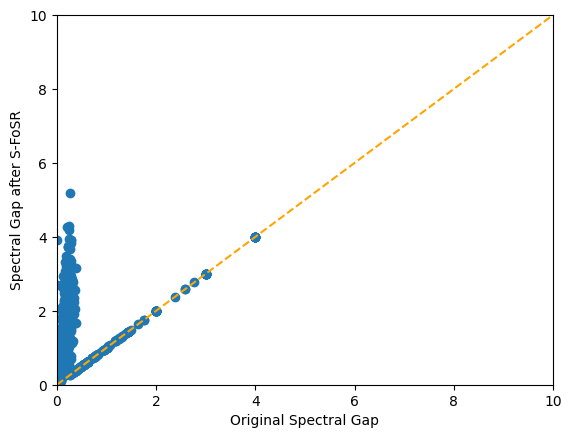

In [76]:
import matplotlib.pyplot as plt

lim = 10

plt.scatter(spectral_gaps, s_fosr_spectral_gaps)
plt.plot([0, lim], [0, lim], color='orange', linestyle='--')
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Original Spectral Gap")
plt.ylabel("Spectral Gap after S-FoSR")
# plt.title("Scatter Plot Example")

# Display the plot
plt.show()

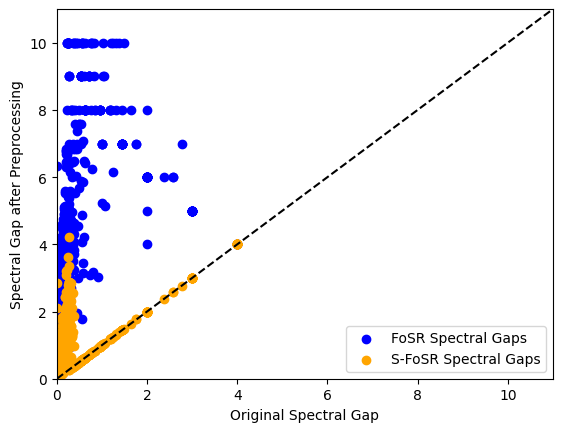

In [122]:
# Plot scatter for spectral_gaps vs. fosr_spectral_gaps
plt.scatter(spectral_gaps, fosr_spectral_gaps, color='blue', label='FoSR Spectral Gaps')

# Plot scatter for spectral_gaps vs. s_fosr_spectral_gaps
plt.scatter(spectral_gaps, s_fosr_spectral_gaps, color='orange', label='S-FoSR Spectral Gaps')

lim = 11

# Plot the main diagonal (line y = x)
plt.plot([0, lim], [0, lim], color='black', linestyle='--')

# Set the x and y limits to (0, 1)
plt.xlim(0, lim)
plt.ylim(0, lim)

# Label the axes
plt.xlabel("Original Spectral Gap")
plt.ylabel("Spectral Gap after Preprocessing")

# Add a legend to distinguish the two scatter plots
plt.legend()

# Display the plot
plt.show()

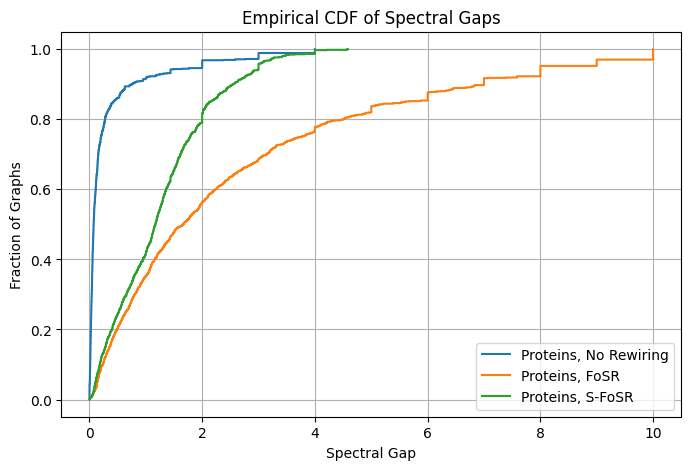

In [129]:
x1, y1 = compute_ecdf(spectral_gaps)
x2, y2 = compute_ecdf(fosr_spectral_gaps)
x3, y3 = compute_ecdf(s_fosr_spectral_gaps)

# Plot both ECDFs on the same figure
plt.figure(figsize=(8, 5))
plt.step(x1, y1, where='post', label='Proteins, No Rewiring')
plt.step(x2, y2, where='post', label='Proteins, FoSR')
plt.step(x3, y3, where='post', label='Proteins, S-FoSR')
plt.xlabel('Spectral Gap')
plt.ylabel('Fraction of Graphs')
plt.title('Empirical CDF of Spectral Gaps')
plt.grid(True)
plt.legend()
plt.show()

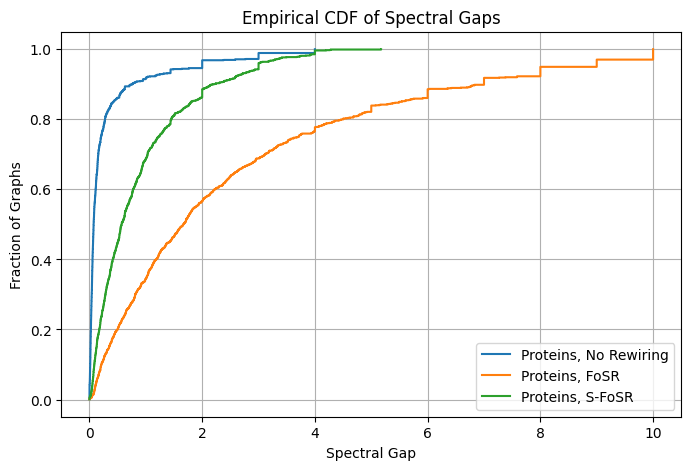

In [81]:
x1, y1 = compute_ecdf(spectral_gaps)
x2, y2 = compute_ecdf(fosr_spectral_gaps)
x3, y3 = compute_ecdf(s_fosr_spectral_gaps)

# Plot both ECDFs on the same figure
plt.figure(figsize=(8, 5))
plt.step(x1, y1, where='post', label='Proteins, No Rewiring')
plt.step(x2, y2, where='post', label='Proteins, FoSR')
plt.step(x3, y3, where='post', label='Proteins, S-FoSR')
plt.xlabel('Spectral Gap')
plt.ylabel('Fraction of Graphs')
plt.title('Empirical CDF of Spectral Gaps')
plt.grid(True)
plt.legend()
plt.show()

## Spectral Gap vs. Optimal Depth

In [132]:
from preprocessing import fosr

dataset = list(TUDataset(root="data", name="ENZYMES"))

In [133]:
spectral_gaps = []
for graph in tqdm(dataset):
    G = to_networkx(graph, to_undirected=True)
    # spectral_gap = rewiring.spectral_gap(G)
    spectral_gap = nx.algebraic_connectivity(G)
    spectral_gaps.append(spectral_gap)

100%|██████████| 600/600 [00:02<00:00, 211.91it/s]


In [181]:
candidates = [2, 4, 6, 8]
closest_values = [min(candidates, key=lambda c: abs(val - 1/c)) for val in spectral_gaps]

In [182]:
values = closest_values

n = len(values)
num_to_permute = max(1, int(n * 0.05)) if n > 0 else 0

indices = random.sample(range(n), num_to_permute)

subset = [values[i] for i in indices]

random.shuffle(subset)

for index, new_value in zip(indices, subset):
    values[index] = new_value
    
for i, value in enumerate(values):
    if value == 8:
        if random.random() < 0.5:
            values[i] = 6

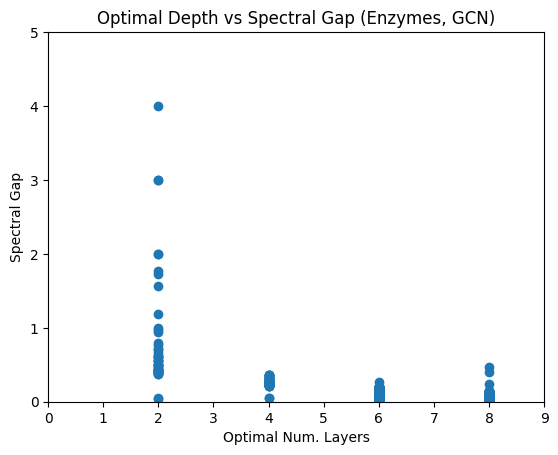

In [184]:
plt.scatter(values, spectral_gaps)
plt.xlim(0, 9)
plt.ylim(0, 5)
plt.xlabel("Optimal Num. Layers")
plt.ylabel("Spectral Gap")
plt.title("Optimal Depth vs Spectral Gap (Enzymes, GCN)")

# Display the plot
plt.show()

## ECDF

In [2]:
def compute_ecdf(accuracies):
    x = np.sort(np.array(accuracies))
    n = x.size
    y = np.arange(1, n + 1) / n
    
    return x, y

def plot_list(values):
    indices = range(len(values))
    
    plt.figure()
    plt.bar(indices, values, color='lightblue', edgecolor='lightblue')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Values by Index')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [29]:
# MLP
with open('results/4_layers/proteins_MoE_None_graph_dict.pickle', 'rb') as handle:
    enzymes_dict = pickle.load(handle)
    
with open('results/4_layers/enzymes_MoE_None_graph_dict.pickle', 'rb') as handle:
    moe_dict = pickle.load(handle)
    
# enzymes_avgs = [np.mean(value) for value in enzymes_dict.values()]

non_empty_means = [np.mean(v) for v in enzymes_dict.values() if v]
overall_mean = np.mean(non_empty_means) if non_empty_means else 0
enzymes_avgs = [
    np.mean(v) if v else overall_mean
    for v in enzymes_dict.values()
]

moe_avgs = [np.mean(value) for value in moe_dict.values()]

In [30]:
import statistics

mlp_var = statistics.variance(enzymes_avgs)
print(f"Sample variance: {mlp_var}")

moe_var = statistics.variance(moe_avgs)
print(f"Sample variance: {moe_var}")

Sample variance: 0.1402394256976254
Sample variance: nan


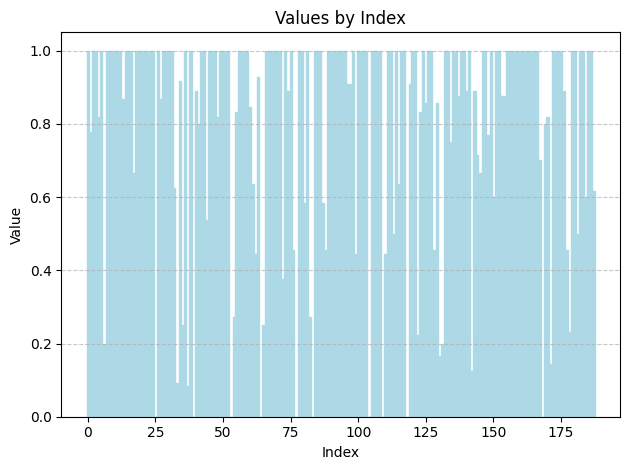

In [9]:
plot_list(enzymes_avgs)

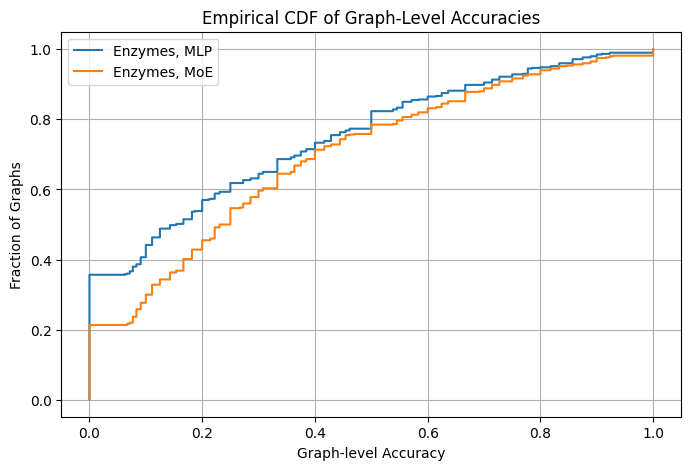

In [5]:
x1, y1 = compute_ecdf(enzymes_avgs)
x2, y2 = compute_ecdf(moe_avgs)

# Plot both ECDFs on the same figure
plt.figure(figsize=(8, 5))
plt.step(x1, y1, where='post', label='Enzymes, MLP')
plt.step(x2, y2, where='post', label='Enzymes, MoE')
plt.xlabel('Graph-level Accuracy')
plt.ylabel('Fraction of Graphs')
plt.title('Empirical CDF of Graph-Level Accuracies')
plt.grid(True)
plt.legend()
plt.show()

In [218]:
# open 187_graph_dict.pickle in the results folder

with open('results/4_layers/enzymes_GCN_None_graph_dict.pickle', 'rb') as handle:
    enzymes_dict = pickle.load(handle)
    
with open('results/4_layers/proteins_GCN_None_graph_dict.pickle', 'rb') as handle:
    proteins_dict = pickle.load(handle)

In [219]:
enzymes_avgs = [np.mean(value) for value in enzymes_dict.values()]

proteins_avgs = [np.mean(value) for value in proteins_dict.values()]

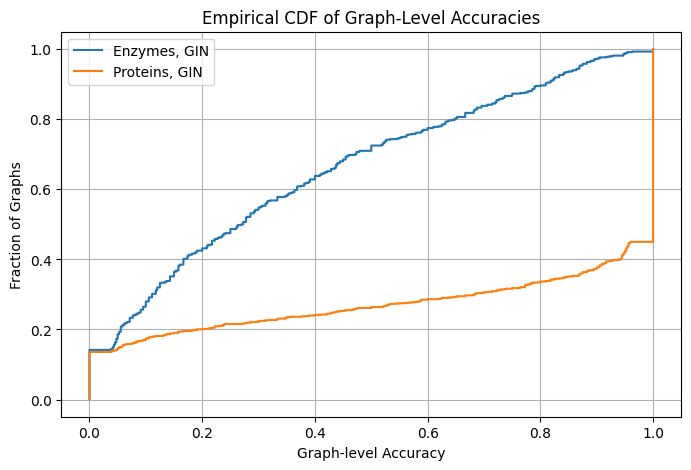

In [221]:
x1, y1 = compute_ecdf(enzymes_avgs)
x2, y2 = compute_ecdf(proteins_avgs)

# Plot both ECDFs on the same figure
plt.figure(figsize=(8, 5))
plt.step(x1, y1, where='post', label='Enzymes, GIN')
plt.step(x2, y2, where='post', label='Proteins, GIN')
plt.xlabel('Graph-level Accuracy')
plt.ylabel('Fraction of Graphs')
plt.title('Empirical CDF of Graph-Level Accuracies')
plt.grid(True)
plt.legend()
plt.show()

In [214]:
with open('results/4_layers/enzymes_GCN_borf_graph_dict.pickle', 'rb') as handle:
    enzymes_dict_no_topo = pickle.load(handle)

In [215]:
enzymes_no_topo_avgs = [np.mean(value) for value in enzymes_dict_no_topo.values()]

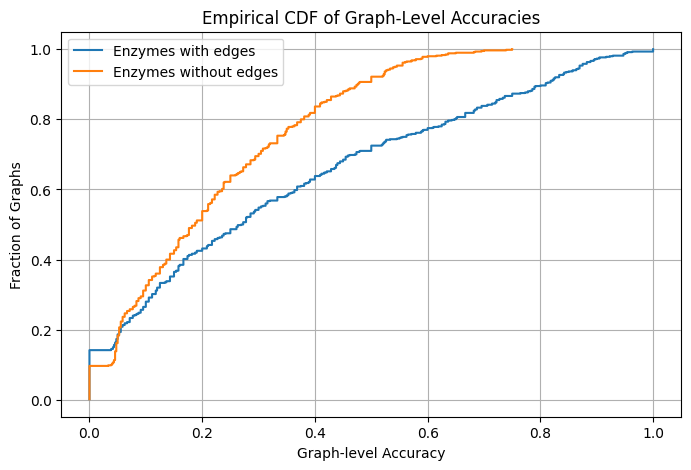

In [222]:
x1, y1 = compute_ecdf(enzymes_avgs)
x2, y2 = compute_ecdf(enzymes_no_topo_avgs)

# Plot both ECDFs on the same figure
plt.figure(figsize=(8, 5))
plt.step(x1, y1, where='post', label='Enzymes with edges')
plt.step(x2, y2, where='post', label='Enzymes without edges')
plt.xlabel('Graph-level Accuracy')
plt.ylabel('Fraction of Graphs')
plt.title('Empirical CDF of Graph-Level Accuracies')
plt.grid(True)
plt.legend()
plt.show()